# Skip-gram Word2Vec with Negative Sampling

## Good Reading Sources

* A really good [conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/) of Word2Vec from Chris McCormick 
* [First Word2Vec paper](https://arxiv.org/pdf/1301.3781.pdf) from Mikolov et al.
* [Neural Information Processing Systems, paper](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) with improvements for Word2Vec also from Mikolov et al.


---
## Word2Vec

2 architectures for implementing Word2Vec:
>* CBOW (Continuous Bag-Of-Words) 
* Skip-gram

* Here we implement **skip-gram architecture** with **negative sampling**, since it performs better than CBOW & trains faster with negative sampling. 

* We feed the model with a word and make it predict the surrounding words, so that it can learn representations for words that show up in similar contexts.

---
## 1. Load Data

Load [text8 dataset](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/October/5bbe6499_text8/text8.zip), a file of cleaned up ***Wikipedia articles*** by Matt Mahoney 

In [2]:
!rm -r sample_data
from google.colab import drive, files
drive.mount('/content/gdrive')

device = 'cuda' if torch.cuda.is_available else 'cpu'

rm: cannot remove 'sample_data': No such file or directory
Mounted at /content/gdrive


In [3]:
with open('gdrive/MyDrive/text8') as f:
    text = f.read()

print(text[:100])  # first 100 characters

 anarchism originated as a term of abuse first used against early working class radicals including t


# 2. Pre-process text

* Convert any punctuation into tokens, e.g. a period is changed to ` <PERIOD> `. (Note: `text8` dataset doesn't contain any periods.)
* Remove all words that show up ≤5 times in the dataset to
  * reduce issues due to noise in the data 
  * improve the quality of the vector representations
* Return a list of preprocessed words in the text

In [4]:
import re
from collections import Counter

def preprocess(text):

    # Convert all text to lowercase
    text = text.lower()

    # Replace punctuation with tokens so we can use them in our model
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with 5 or less occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words

In [5]:
# get vocabulary 
words = preprocess(text)
print(text[:100])
print(words[:30])

 anarchism originated as a term of abuse first used against early working class radicals including t
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst']


In [6]:
print("Total # of words: {}".format(len(words)))
print("# of unique words: {}".format(len(set(words)))) 

Total # of words: 16680599
# of unique words: 63641


# 3. Create Dictionaries

Sorted in descending frequency order (e.g. most frequent word `"the"` is assigned as `0`).


In [7]:
def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    - words: list of words
    - return: 2 dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True) # descending freq order
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

In [8]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
print(vocab_to_int)

{'the': 0, 'of': 1, 'and': 2, 'one': 3, 'in': 4, 'a': 5, 'to': 6, 'zero': 7, 'nine': 8, 'two': 9, 'is': 10, 'as': 11, 'eight': 12, 'for': 13, 's': 14, 'five': 15, 'three': 16, 'was': 17, 'by': 18, 'that': 19, 'four': 20, 'six': 21, 'seven': 22, 'with': 23, 'on': 24, 'are': 25, 'it': 26, 'from': 27, 'or': 28, 'his': 29, 'an': 30, 'be': 31, 'this': 32, 'which': 33, 'at': 34, 'he': 35, 'also': 36, 'not': 37, 'have': 38, 'were': 39, 'has': 40, 'but': 41, 'other': 42, 'their': 43, 'its': 44, 'first': 45, 'they': 46, 'some': 47, 'had': 48, 'all': 49, 'more': 50, 'most': 51, 'can': 52, 'been': 53, 'such': 54, 'many': 55, 'who': 56, 'new': 57, 'used': 58, 'there': 59, 'after': 60, 'when': 61, 'into': 62, 'american': 63, 'time': 64, 'these': 65, 'only': 66, 'see': 67, 'may': 68, 'than': 69, 'world': 70, 'i': 71, 'b': 72, 'would': 73, 'd': 74, 'no': 75, 'however': 76, 'between': 77, 'about': 78, 'over': 79, 'years': 80, 'states': 81, 'people': 82, 'war': 83, 'during': 84, 'united': 85, 'known': 

# 4. Perform Word Subsampling

* Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. 
* Discarding some of them (aka Subsampling) can achieve :
  * **removing of noise in data** 
  * faster training 
  * better representations. 
* Each word $w_i$ in the training set is discarded with probability: 
  * $t$ : threshold (something small like 1e-5)
  * $f(w_i)$ : frequency (in decimals) of word $w_i$ 

$$ P(w_i) = 1 - \sqrt{\frac{t}{f(w_i)}} $$

* Use: discard if `random.random() < probs[word]`

In [9]:
import random
import numpy as np

def subsample_words(int_words, threshold = 1e-5):
  word_counts = Counter(int_words)
  total_n_words = len(int_words)

  freq_ratios = {word: count/total_n_words for word, count in word_counts.items()}
  p_drop = {word: 1 - np.sqrt(threshold/freq_ratios[word]) for word in word_counts}

  return [word for word in int_words if random.random() < (1 - p_drop[word])]

In [10]:
  train_words = subsample_words(int_words)
  print(len(int_words))
  print(len(train_words))
  print(len(train_words)/len(int_words))

16680599
4628645
0.2774867377364566


# 5. Generate Context Targets

For each word in the text, define **_Context_** by grabbing the surrounding words in a window of size $C$. 

In [20]:
import random
def get_target(words, idx, max_window_size=5):
    R = random.randint(1, max_window_size)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

In [21]:
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

for _ in range(5):
  target = get_target(int_text, idx=idx, max_window_size=5)
  print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]
Target:  [2, 3, 4, 6, 7, 8]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]
Target:  [4, 6]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


# 6. Generate Batches 

* Grab `batch_size` words from a words list
* Then for each of those words, get the context target words in a window.

In [41]:
def get_batches(words, batch_size, max_window_size=5):
  # only full batches
  n_batches = len(words)//batch_size
  words = words[:n_batches*batch_size]
  for i in range(0, len(words), batch_size):
    batch_of_center_words = words[i:i+batch_size]   # current batch of words
    batch_x, batch_y = [], []  

    for ii in range(len(batch_of_center_words)):  # range(batch_size) unless truncated at the end
      x = [batch_of_center_words[ii]]             # single word
      y = get_target(words=batch_of_center_words, idx=ii, max_window_size=max_window_size)  # list of context words

      batch_x.extend(x * len(y)) # repeat the center word (n_context_words) times
      batch_y.extend(y)
  
    yield batch_x, batch_y       # ex) [1,1,2,2,2,2,3,3,3,3], [0,2,0,1,3,4,1,2,4,5]

In [22]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, max_window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


# 7. Define COSINE SIMILARITY Function for Validation Metric

* Choose a few common words & a few uncommon words
* Print their **closest words** using Cosine Similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$

In [23]:
def cosine_similarity(embedding, n_valid_words=16, valid_window=100):
  """ Returns the cosine similarity of validation words with words in the embedding matrix.
      embedding: PyTorch embedding module
      n_valid_words: # of validation words (recommended to have even numbers)
  """
  all_embeddings = embedding.weight  # (n_vocab, n_embed) 
  # sim = (a . b) / |a||b|
  magnitudes = all_embeddings.pow(2).sum(dim=1).sqrt().unsqueeze(0) # (1, n_vocab)
  
  # Pick validation words from 2 ranges: (0, window): common words & (1000, 1000+window): uncommon words 
  valid_words = random.sample(range(valid_window), n_valid_words//2) + random.sample(range(1000, 1000+valid_window), n_valid_words//2)
  valid_words = torch.LongTensor(np.array(valid_words)).to(device) # (n_valid_words, 1)

  valid_embeddings = embedding(valid_words) # (n_valid_words, n_embed)
  # (n_valid_words, n_embed) * (n_embed, n_vocab) --> (n_valid_words, n_vocab) / 1, n_vocab)
  similarities = torch.mm(valid_embeddings, all_embeddings.t()) / magnitudes  # (n_valid_words, n_vocab)
  
  return valid_words, similarities

# 8. Define SkipGram model with [Negative Sampling](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)


Instead of updating all tokens' embeddings, approximate the loss from softmax layer by only updating a small subset of weights assciated with:
* center word
* context words
* noise words

In the model, we use 2 separate embedding tables, one for input words & one for output words. 



In [25]:
import torch
from torch import nn
import torch.optim as optim

* `nn.Embedding` layer is the same as a Linear layer with one-hot-encoded input. You could define the layer as `nn.Linear(1000, 30)` & represent each word as a one-hot vector, e.g., `[0,0,1,0,...,0]` where the length of the vector is 1000.

* It is an ***embedding lookup table*** which is just a weight matrix & the lookup is just a shortcut for the matrix multiplication. 

* It is trained just like any weight matrix.

In [34]:
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist=None):
        super().__init__()
        
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        
        self.in_embed = nn.Embedding(n_vocab, n_embed)
        self.out_embed = nn.Embedding(n_vocab, n_embed)
        
        # Initialize both embedding tables with uniform distribution
        self.in_embed.weight.data.uniform_(-1, 1)
        self.out_embed.weight.data.uniform_(-1, 1)
        

    def forward_input(self, input_words):
        input_vectors = self.in_embed(input_words)
        return input_vectors  # input vector embeddings
    

    def forward_target(self, output_words):
        output_vectors = self.out_embed(output_words)
        return output_vectors  # output vector embeddings
    

    def forward_noise(self, batch_size, n_samples=5):
        """ Generate noise vectors with shape (batch_size, n_samples, n_embed)"""
        # If no Noise Distribution specified, sample noise words uniformly from vocabulary
        if self.noise_dist is None:
            noise_dist = torch.ones(self.n_vocab)
        else:
            noise_dist = self.noise_dist
            
        # torch.multinomial :
        # Returns a tensor where each row contains (num_samples) **indices** sampled from 
        # multinomial probability distribution located in the corresponding row of tensor input.
        noise_words = torch.multinomial(input       = noise_dist,           # input tensor containing probabilities
                                        num_samples = batch_size*n_samples, # number of samples to draw
                                        replacement = True)
        noise_words = noise_words.to(device)
        
        # use context matrix for embedding noise samples
        noise_vectors = self.out_embed(noise_words).view(batch_size, n_samples, self.n_embed)
        
        return noise_vectors

# 9. Define Loss Class
Modified loss function that only cares about :
* current example 
* small subset of noise examples

## Loss Formula
$$
- \large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)} -
\sum_i^N \mathbb{E}_{w_i \sim P_n(w)}\log{\sigma\left(-u_{w_N}\hspace{0.001em}^\top v_{w_I}\right)}
$$

* $u_{w_O}\hspace{0.001em}$ : output embeddings
* $v_{w_I}$ : input embeddings
* $u_{w_N}$ : noise embeddings

 

$$\large \log{\sigma\left(u_{w_O}\hspace{0.001em}^\top v_{w_I}\right)}$$

* Take the **log-sigmoid** of the **inner product of output word vector & input word vector**. 
  * Pushes *P(model will predict the correct word $w_O$)* towards 1.

$$\large \sum_i^N \mathbb{E}_{w_N \sim P_n(w)}$$ 

* Sum over words $w_N$ drawn from a noise distribution $w_N \sim P_n(w)$. 
* For $P_n(w)$, we can use the unigram distribution $U(w)$ that takes into account the frequency that each word shows up in text corpus.
* The authors found the best distribution to be $U(w)^{3/4}$.

$$\large \log{\sigma\left(-u_{w_N}\hspace{0.001em}^\top v_{w_I}\right)},$$ 

* take the **log-sigmoid** of the ***negated*** **inner product of a noise vector with the input vector**. 
  * Pushes *P(model will predict the noise words)* towards 0.

In [27]:
class NegativeSamplingLoss(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, 
              input_vectors, 
              output_vectors, 
              noise_vectors):
      
    batch_size, embed_size = input_vectors.shape
    
    input_vectors = input_vectors.view(batch_size, embed_size, 1)   # batch of column vectors
    output_vectors = output_vectors.view(batch_size, 1, embed_size) # batch of row vectors
    
    # log-sigmoid loss for correct pairs
    out_loss = torch.bmm(output_vectors, input_vectors).sigmoid().log().squeeze()
    
    # log-sigmoid loss for incorrect pairs
    noise_loss = torch.bmm(noise_vectors.neg(), input_vectors).sigmoid().log()
    noise_loss = noise_loss.squeeze().sum(1)  # sum the losses over the sample of noise vectors

    return -(out_loss + noise_loss).mean()  # average batch loss

# 10. Define Noise Distribution

In [28]:
# As defined in the paper by Mikolov et all.
freq = Counter(int_words)
freq_ratio = {word:cnt/len(vocab_to_int) for word, cnt in freq.items()}        
freq_ratio = np.array(sorted(freq_ratio.values(), reverse=True))
unigram_dist = freq_ratio / freq_ratio.sum() 
noise_dist = torch.from_numpy(unigram_dist**0.75 / np.sum(unigram_dist**0.75))

# 11. Define Model, Loss, & Optimizer 

In [51]:
from torch import optim

embedding_dim = 300
model = SkipGramNeg(len(vocab_to_int), 
                                 embedding_dim, 
                                 noise_dist )
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.003)

# 12. Train!

In [75]:
def train_skipgram(model,
                   criterion,
                   optimizer,
                   int_words,
                   n_negative_samples=5,
                   batch_size=512,
                   n_epochs=5,
                   print_every=1500,
                   ):
  model.to(device)
  
  step = 0
  for epoch in range(n_epochs):
    for inputs, targets in get_batches(int_words, batch_size=batch_size):
      step += 1
      inputs = torch.LongTensor(inputs).to(device)    # [b*n_context_words]
      targets = torch.LongTensor(targets).to(device)  # [b*n_context_words]
      
      embedded_input_words = model.forward_input(inputs)
      embedded_target_words = model.forward_target(targets)
      embedded_noise_words = model.forward_noise(batch_size=inputs.shape[0], 
                                                  n_samples=n_negative_samples)

      loss = criterion(embedded_input_words, embedded_target_words, embedded_noise_words)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      if (step % print_every) == 0:
        print("Epoch: {}/{}".format((epoch+1), n_epochs))
        print("Loss: {:.4f}".format(loss.item()))
        valid_idxs, similarities = cosine_similarity(model.in_embed)
        _, closest_idxs = similarities.topk(6)
        valid_idxs, closest_idxs = valid_idxs.to('cpu'), closest_idxs.to('cpu')
        
        for ii, v_idx in enumerate(valid_idxs):
          closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
          print(int_to_vocab[v_idx.item()] + " | "+ ", ".join(closest_words))

        print("\n...\n")

In [76]:
train_skipgram(model,
               criterion,
               optimizer,
               int_words,
               n_negative_samples=5)

Epoch: 1/5
Loss: 1.5435
the | of, and, this, a, in
states | united, north, kingdom, america, caribbean
such | as, well, other, or, and
not | that, do, does, but, they
were | are, was, had, have, they
while | but, and, who, though, as
be | can, have, it, may, not
most | some, more, many, the, common
professional | association, universities, football, league, dvd
institute | association, nobel, university, research, architecture
gold | nicky, ore, copper, silver, yogi
placed | slid, amato, convoy, honey, princesses
centre | station, park, located, webpage, network
powers | authorizes, emperor, amendments, pose, existence
bbc | links, external, factbook, news, cia
bill | claude, hopkins, film, warez, willem
...
Epoch: 1/5
Loss: 2.9084
states | united, kingdom, state, president, america
some | many, these, other, most, those
and | with, also, or, from, of
than | more, rather, less, or, but
american | d, nine, b, english, one
he | it, him, she, his, who
also | and, as, which, by, it
people 

# 13. Visualize the Embedded Word Vectors with t-SNE Plots

Use t-SNE to visualize how our high-dimensional word vectors cluster together. 

Note : Check out [this post from Christopher Olah](http://colah.github.io/posts/2014-10-Visualizing-MNIST/) to learn more about t-SNE and other ways to visualize high-dimensional data.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [ ]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.in_embed.weight.to('cpu').data.numpy()

In [ ]:
viz_words = 380
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

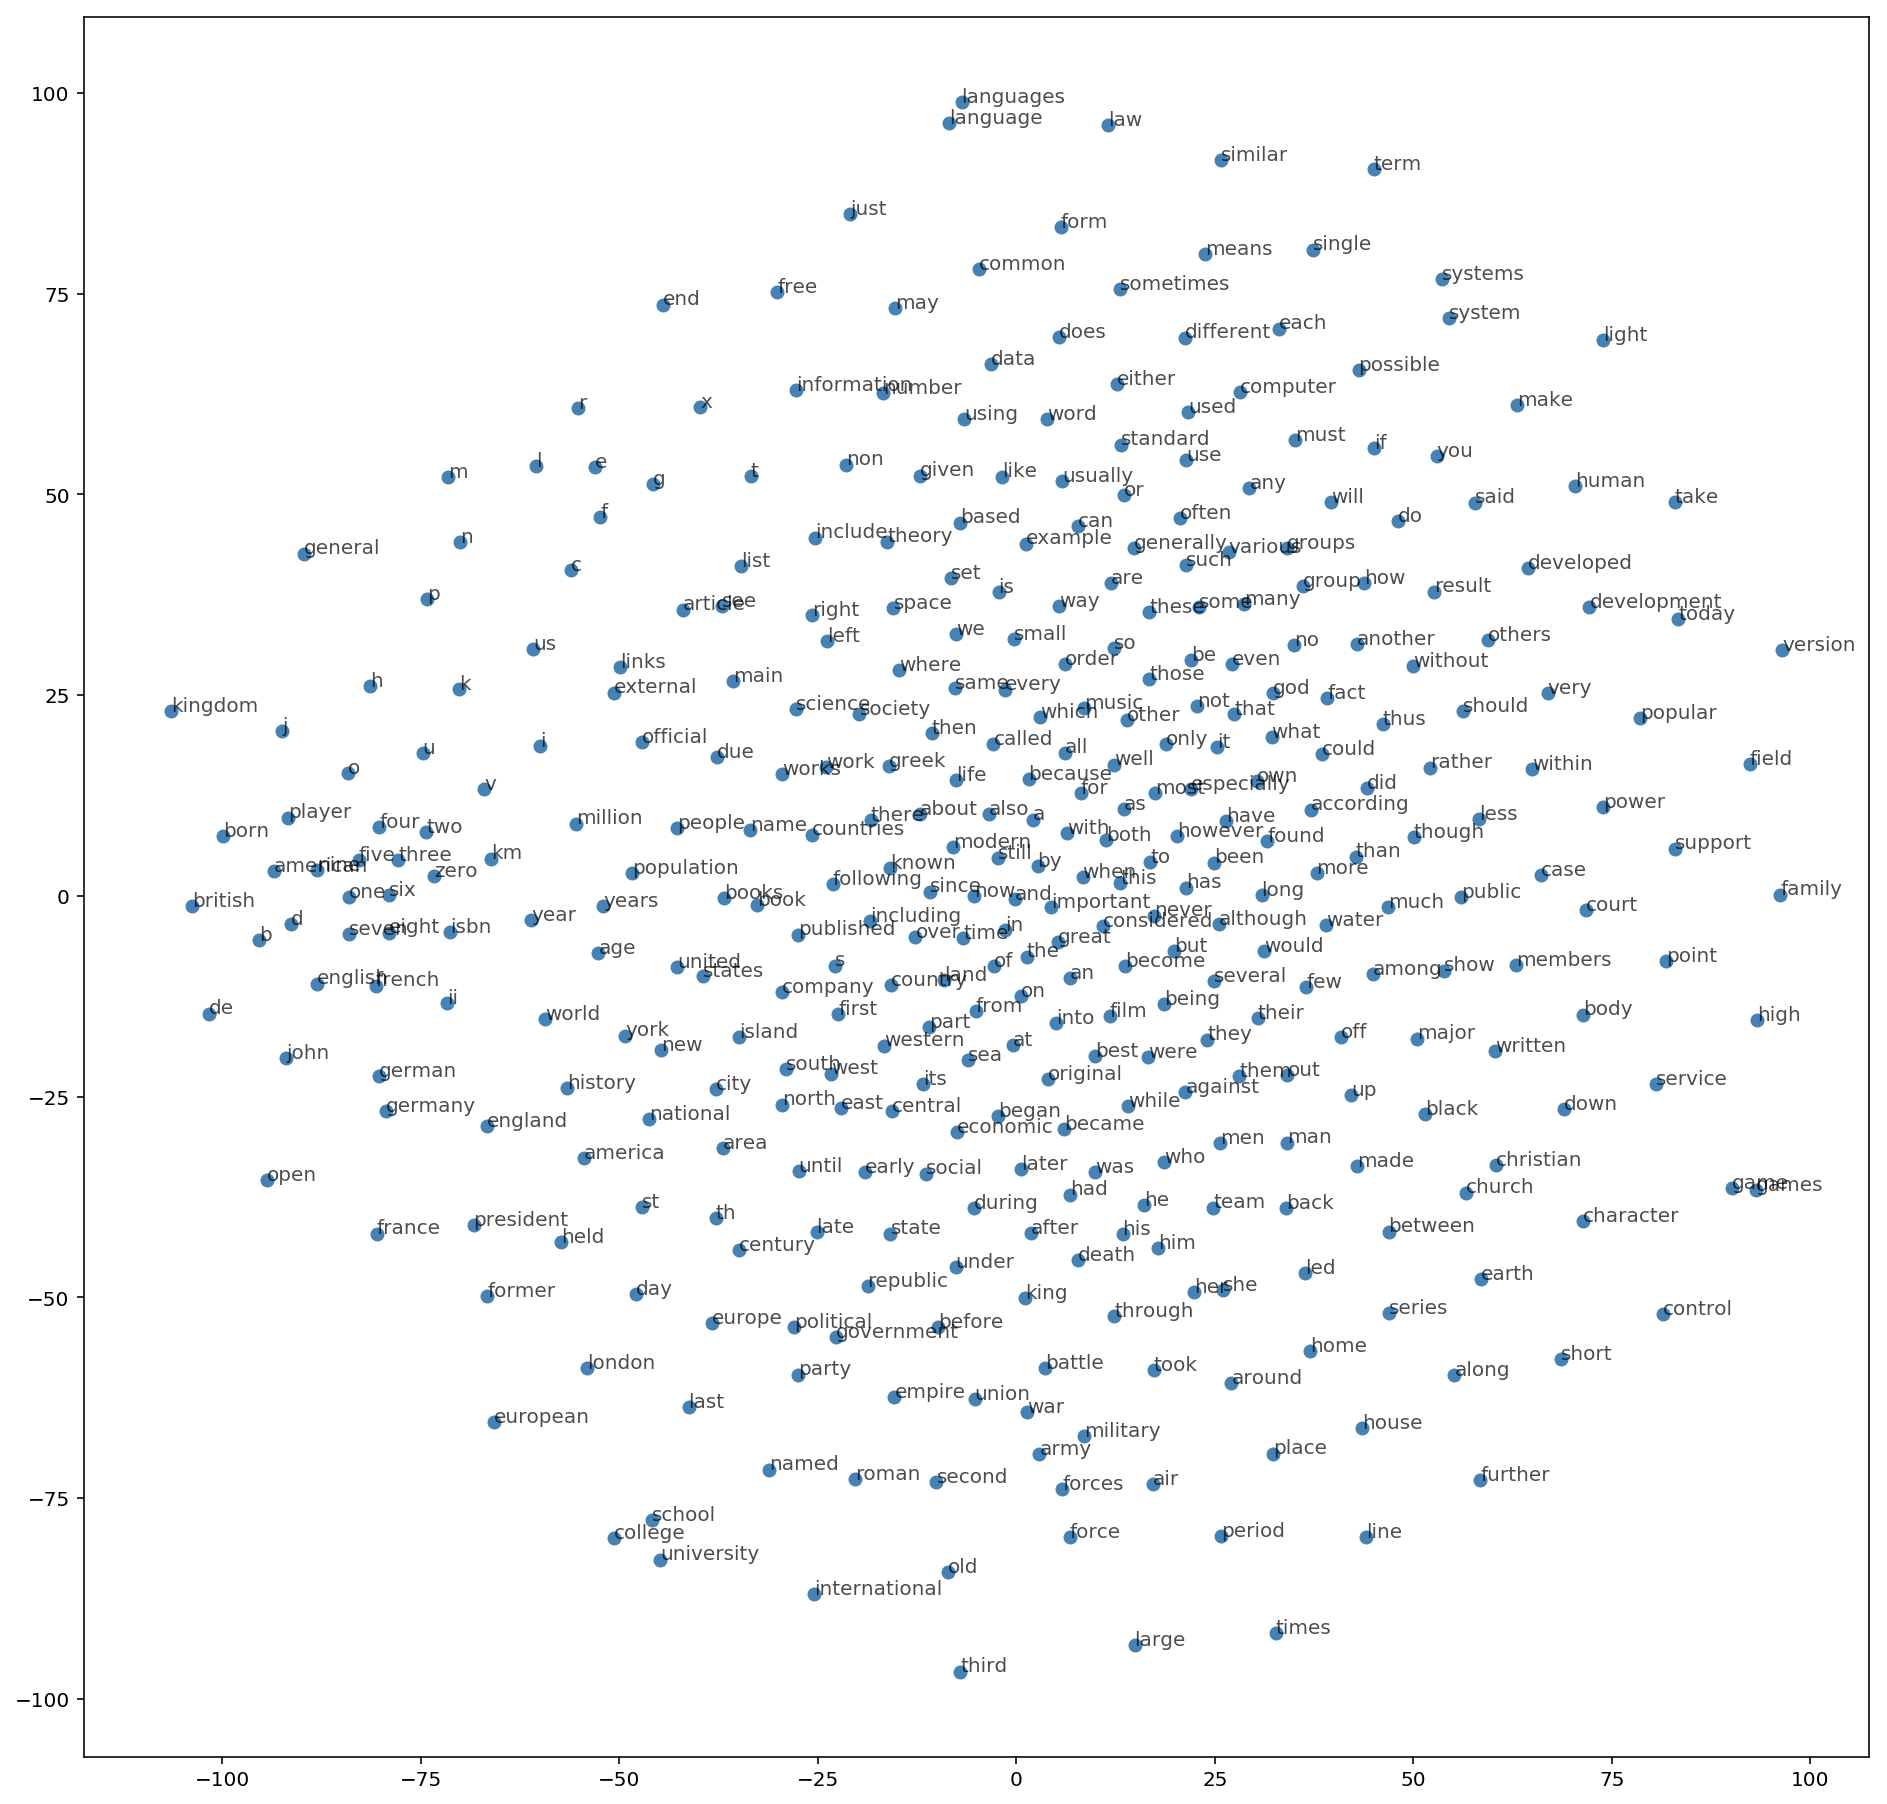

In [ ]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)